In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Chemin vers le dossier dataset dans Google Drive
data_dir = '/content/drive/MyDrive/try/car/data1a'

# Afficher la liste des fichiers dans le dossier dataset
files = os.listdir(data_dir)
print(files)

['validation', 'testing', 'training']


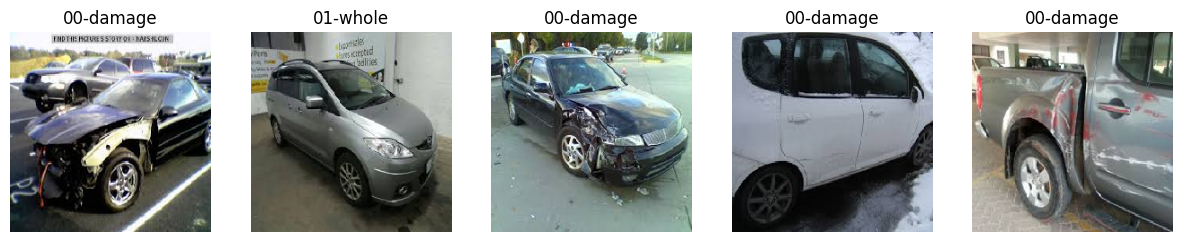

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Chemins vers vos dossiers
train_path = '/content/drive/MyDrive/try/car/data1a/training'
validation_path = '/content/drive/MyDrive/try/car/data1a/validation'
test_path = '/content/drive/MyDrive/try/car/data1a/testing'

# Fonction pour afficher des images aléatoires depuis un dossier
def display_random_images_from_folder(folder_path, num_images=5):
    class_folders = [os.path.join(folder_path, class_folder) for class_folder in os.listdir(folder_path)]
    images = []
    for class_folder in class_folders:
        images += [os.path.join(class_folder, img) for img in os.listdir(class_folder)]

    random_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(random_images):
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(img_path)))
        plt.axis('off')

    plt.show()

# Afficher quelques images aléatoires depuis le dossier d'entraînement
display_random_images_from_folder(train_path)


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

# Préparer les générateurs de données
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 1840 images belonging to 2 classes.
Found 425 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
# Charger VGG19 avec les poids préentraînés sur ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dropout
# Ajouter les nouvelles couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Entraîner le modèle
history =model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
58/58 [==============================] - 30s 512ms/step - loss: 0.0900 - accuracy: 0.9679 - val_loss: 0.1862 - val_accuracy: 0.9365
Epoch 2/10
58/58 [==============================] - 30s 511ms/step - loss: 0.0615 - accuracy: 0.9761 - val_loss: 0.2419 - val_accuracy: 0.9082
Epoch 3/10
58/58 [==============================] - 33s 564ms/step - loss: 0.0732 - accuracy: 0.9728 - val_loss: 0.3053 - val_accuracy: 0.9106
Epoch 4/10
58/58 [==============================] - 31s 530ms/step - loss: 0.0628 - accuracy: 0.9761 - val_loss: 0.1938 - val_accuracy: 0.9365
Epoch 5/10
58/58 [==============================] - 31s 535ms/step - loss: 0.0226 - accuracy: 0.9913 - val_loss: 0.2717 - val_accuracy: 0.9294
Epoch 6/10
58/58 [==============================] - 33s 566ms/step - loss: 0.0288 - accuracy: 0.9902 - val_loss: 0.3205 - val_accuracy: 0.9200
Epoch 7/10
58/58 [==============================] - 32s 548ms/step - loss: 0.2510 - accuracy: 0.9043 - val_loss: 0.1878 - val_accuracy: 0.9271

In [ ]:
# Évaluer le modèle
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 300ms/step - loss: 0.7302 - accuracy: 0.8000
Test Loss: 0.7301796674728394
Test Accuracy: 0.800000011920929


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Générer les prédictions
y_pred = model.predict(test_generator)
# Convertir les probabilités en classes binaires
y_pred = (y_pred > 0.5).astype(int).flatten()

# Rapport de classification
print(classification_report(test_generator.classes, y_pred, target_names=['non-damaged', 'damaged']))

1/1 [==============================] - 0s 102ms/step
              precision    recall  f1-score   support

 non-damaged       0.50      0.60      0.55        10
     damaged       0.50      0.40      0.44        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.50      0.50      0.49        20



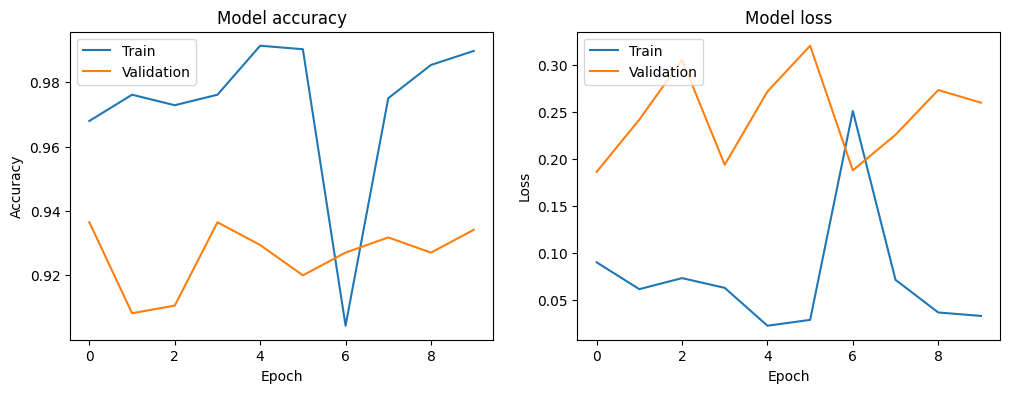

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plots
plt.show()


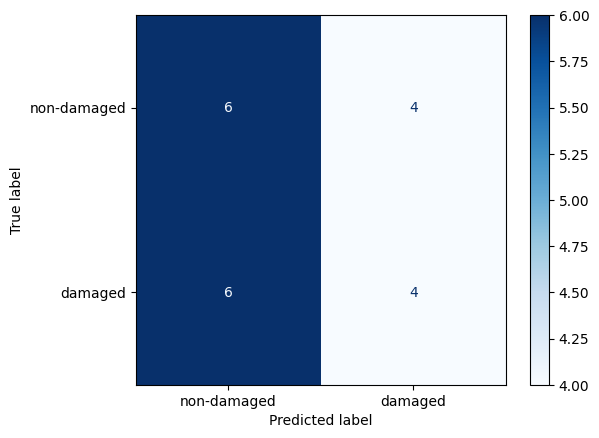

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Matrice de confusion
cm = confusion_matrix(test_generator.classes, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['non-damaged', 'damaged'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

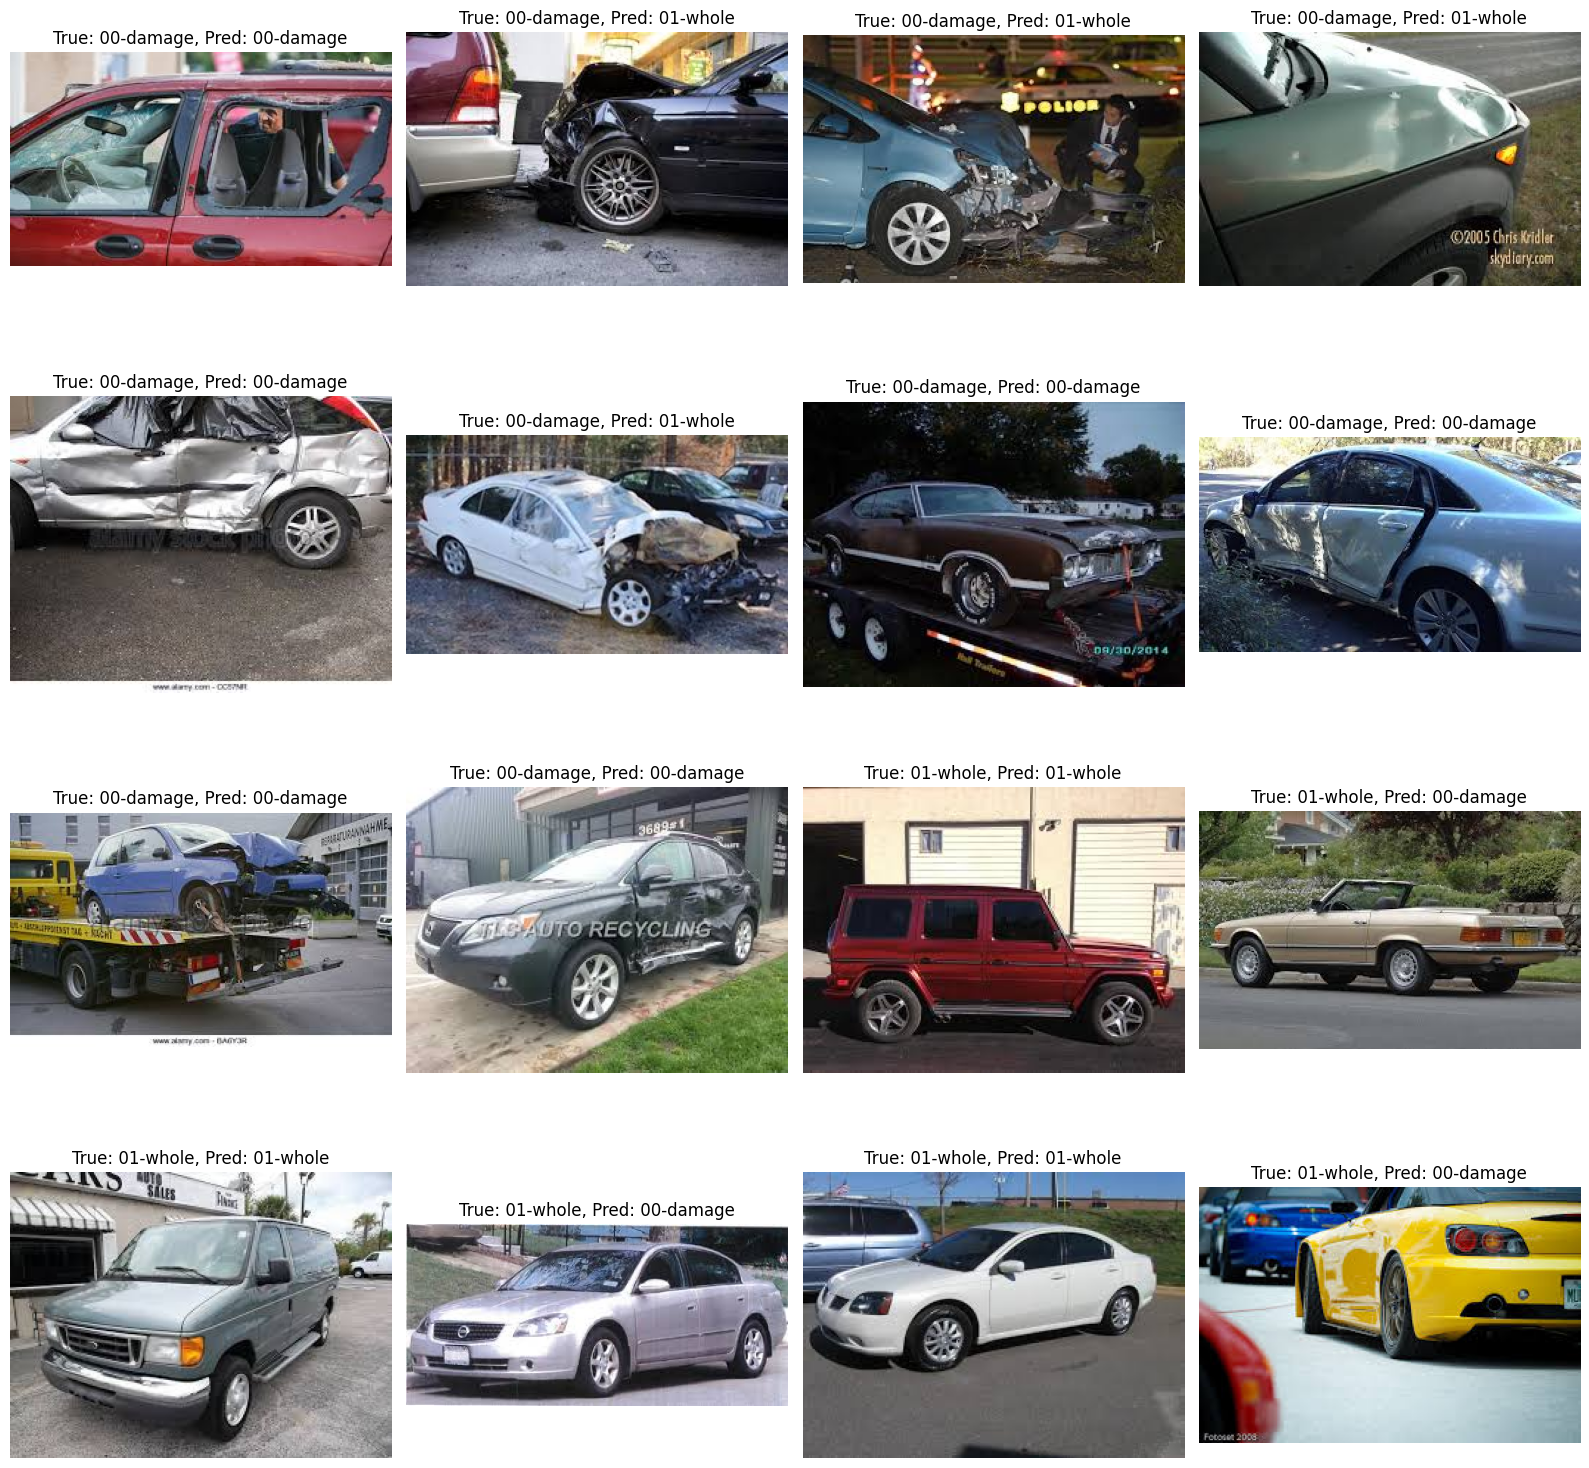

In [ ]:
# Affichage des images de test avec leurs étiquettes réelles et les prédictions
class_names = {v: k for k, v in test_generator.class_indices.items()}

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()
for img, ax, true_label, pred_label in zip(test_generator.filepaths, axes, test_generator.classes, y_pred):
    img = plt.imread(img)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/try/model_vggg.h5')